In [1]:
import os
import numpy as np
import pandas as pd
from ecog_ucsf.block import read_block
from scipy.signal import decimate
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Functions that return channel means and standard deviations,
# calculated over the whole file, a portion of the file defined by
# the 'baseline' textgrid label, or the portion of the file that
# is has the lowest energy over a defined interval.
#
# Return the values for channels 0-255; 'channel' 256 is the mean and
# standard deviation of all channels.

def whole_file(b):
    '''Calculate mean and std over whole file.'''
    return pd.DataFrame({
        'mean': np.append(np.nanmean(b.data, axis=1), np.nanmean(b.data)),
        'std': np.append(np.nanstd(b.data, axis=1), np.nanstd(b.data)),
        'channel': np.arange(257),
        'method': 'whole'
    })

def baseline(b):
    '''Calculate mean and std from predefined baseline region.'''
    btier = b.labels['baseline']
    lab = btier[btier.baseline == 'baseline']
    idx = np.round(
        np.array([lab.t1.iloc[0], lab.t2.iloc[0]]) * b.datarate
    ).astype(np.int32)
    d = b.data[:, np.arange(*idx)]
    return pd.DataFrame({
        'mean': np.append(np.nanmean(d, axis=1), np.nanmean(d)),
        'std': np.append(np.nanstd(d, axis=1), np.nanstd(d)),
        'channel': np.arange(257),
        'method': 'baseline'
    })

def min_energy(b, seconds):
    '''Calculate mean and std from region with least energy.'''
    winsize = np.round(b.datarate * seconds).astype(np.int32)
    energy = np.apply_along_axis(
        np.convolve,
        1,                                     # apply np.convolve() along time axis
        b.data**2, np.ones(winsize), 'valid'   # args for np.convolve()
    )
    minidx = energy.argmin(axis=1)   # indexes of start of the window with min energy per channel
    d = np.array(  # grab minimum energy window for each channel
        [b.data[ci, np.arange(mi, mi+winsize)] for ci, mi in enumerate(minidx)]
    )
    return (pd.DataFrame({
        'mean': np.append(np.nanmean(d, axis=1), np.nanmean(d)),
        'std': np.append(np.nanstd(d, axis=1), np.nanstd(d)),
        'channel': np.arange(257),
        'method': 'min_energy'
    }), energy, minidx, d)

In [3]:
basedir = '../../ecog/datasets'
blockdirs = ['GP31_B40', 'GP31_B34']   # <-- define your own set here
subdir = 'HilbAA_70to150_8band'

In [4]:
# Loop over block dirs and read data. Combine frequency bands and downsample, then
# calculate mean and standard deviation.
blocks = {}
results = []
for f in blockdirs:
    try:
        b = read_block(
            os.path.join(basedir, f),
            subdir,
            converter=lambda chan: decimate(
                chan.mean(axis=1), q=10, axis=0, zero_phase=True
            ),
            replace=False,
            labeltiers=['phone', 'word', 'baseline']
        )
        results.append(whole_file(b))
        results.append(baseline(b))
        data, b.energy, b.minidx, b.mindata = min_energy(b, 5)
        results.append(data)
        blocks[f] = b
    except Exception as e:
        print("Could not process block {:}".format(f))
        print(str(e))
    rdf = pd.concat(results)

In [5]:
# This is your result set. Channel 256 is the mean/standard deviation for all channels in the block.
rdf

,channel,mean,method,std
0,0,1.041738,whole,0.263044
1,1,0.880343,whole,0.217455
2,2,0.543250,whole,0.135252
3,3,0.711413,whole,0.328143
4,4,1.141778,whole,0.370517
5,5,1.082052,whole,0.326661
6,6,0.507126,whole,0.193888
7,7,0.347908,whole,0.150243
8,8,0.329823,whole,0.148972
9,9,0.338875,whole,0.196243


## Sanity checking

Make pairs of plots from four random channels in a random block. The first plot in each pair displays the channel sample data. The 5-second window that was calculated to have the least energy is overplotted in red, with the start marked by a vertical line. The second plot displays the summed energy values for the corresponding window. The minimum energy value is marked by a vertical line.

Block GP31_B40: 
Channels  [ 9 28 73 84]


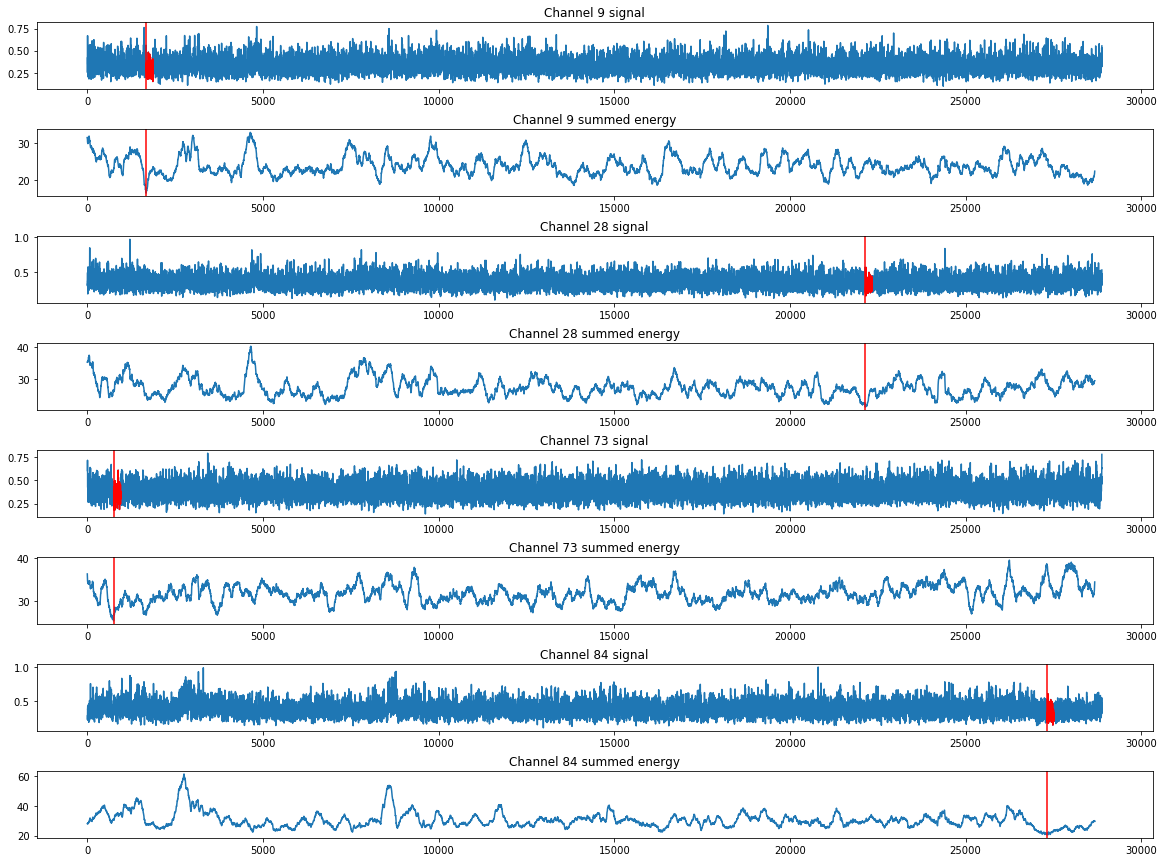

In [6]:
ntrim = 4   # Number of samples to trim off edges to avoid plotting filter artifacts.
channels = np.sort(np.random.randint(0, 256, size=4))    # Select 4 random channels to plot.
randblock = np.random.choice(np.array(blockdirs), 1)[0]  # Select a random block to plot
myblock = blocks[randblock]

print('Block {:}: '.format(randblock))
print('Channels ', channels)
plt.figure(figsize=(20, 15))

for idx, c in enumerate(channels):
    assert(myblock.minidx[c] == np.argmin(myblock.energy[c,:]))
    
    # Trimmed indexes.
    xdataidx = np.arange(ntrim, myblock.data.shape[1]-ntrim)
    xenergyidx = np.arange(ntrim, myblock.energy.shape[1]-ntrim)
    
    # Plot channel signal.
    ax1 = plt.subplot(len(channels) * 2, 1, (idx * 2) + 1, title='Channel {:} signal'.format(c))
    plt.plot(xdataidx, myblock.data[c, xdataidx])
    plt.axvline(myblock.minidx[c], color='r')
    
    # Overplot samples from minimum energy window in red.
    cminrng = np.arange(myblock.minidx[c], myblock.minidx[c] + myblock.mindata.shape[1])
    plt.plot(cminrng, myblock.mindata[c, :], 'r')
    
    # Plot summed energy.
    plt.subplot(len(channels) * 2, 1, (idx * 2) + 2, title='Channel {:} summed energy'.format(c), sharex=ax1)
    plt.plot(myblock.energy[c, xenergyidx])
    plt.axvline(myblock.minidx[c], color='r')

plt.subplots_adjust(hspace=0.6)
